In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import foldnorm, norm
import matplotlib.pyplot as plt

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

#!apt install build-essential pkg-config python3-pip python3-dev cython3 python3-numpy coinor-libipopt1v5 coinor-libipopt-dev
#!pip install cyipopt
# import cyipopt
# from cyipopt import minimize_ipopt

#%pip install pyomo
import pyomo
#from pyomo.environ import ConcreteModel, Set, RangeSet, Param, Var, Objective, Constraint, NonNegativeIntegers, Binary, minimize, value
from pyomo.environ import *
from pyomo.opt import SolverFactory


Data generation

In [68]:
#Define the number of elements in each set I, J, K
i_num = 10
k_num = 1
j_num = 200 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])



In [69]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 5000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 5000), 0)

I.index = I['Point number']


for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 5000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 5000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 5000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 5000), 0)

J.index = J['Point number']
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,4289.0,1417.0
j1,j1,1344.0,2427.0
j2,j2,4490.0,2623.0
j3,j3,1834.0,3296.0
j4,j4,205.0,1555.0
...,...,...,...
i15,i15,2478.0,2178.0
i16,i16,2473.0,3208.0
i17,i17,1040.0,2414.0


In [70]:
# ### PASSAU  ###

# #Define sets of I, J, K, where J contains I and K for Passau

# #Define the number of elements in each set I, J, K

# degree_to_m = 111111

# #Define empty data frames
# I_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
# J_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
# K_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])

# column_types = {
#     'Name': 'str',  # Example: 'int', 'float', 'str', 'datetime64[ns]', etc.
#     'Latitude': 'float',
#     'Longitude': 'float',
#     'Address': 'str'
#     # Add more columns and their data types as needed
# }

# doctors = pd.read_csv('Doctors coordinates.txt', sep = ';', index_col = False, dtype=column_types)

# doctors

# for i in range(len(doctors['Latitude'])):
#     I_coordinates.loc[i, 'Point number'] = 'i'+ str(i)
#     I_coordinates.loc[i, 'Latitude'] = doctors.loc[i, 'Latitude']
#     I_coordinates.loc[i, 'Longitude'] = doctors.loc[i, 'Longitude']

# I_coordinates.index = I_coordinates['Point number']

# I = I_coordinates * degree_to_m
# I['Point number'] = I_coordinates['Point number']


# labs = pd.read_csv('Labs coordinates.txt', sep = ';', index_col = False, dtype=column_types)
# labs

# for k in range(len(labs['Latitude'])):
#     K_coordinates.loc[k, 'Point number'] = 'k'+ str(k)
#     K_coordinates.loc[k, 'Latitude'] = labs.loc[k, 'Latitude']
#     K_coordinates.loc[k, 'Longitude'] = labs.loc[k, 'Longitude']

# K_coordinates.index = K_coordinates['Point number']

# K = K_coordinates * degree_to_m
# K['Point number'] = K_coordinates['Point number']


# #Define range of coordinates

# combined_coordinates = pd.concat([I_coordinates, K_coordinates])

# min_latitude = combined_coordinates['Latitude'].min()
# max_latitude = combined_coordinates['Latitude'].max()
# min_longitude = combined_coordinates['Longitude'].min()
# max_longitude = combined_coordinates['Longitude'].max()

# grid_spacing = 0.0018

# # Create grid points
# grid_points = []
# for lat in np.arange(min_latitude, max_latitude + grid_spacing, grid_spacing):
#     for lon in np.arange(min_longitude, max_longitude + grid_spacing, grid_spacing):
#         grid_points.append((round(lat, 6), round(lon, 6)))

# J_coordinates = pd.DataFrame(grid_points, columns=['Latitude', 'Longitude'])
# J_coordinates['Point number'] = ['j' + str(i) for i in range(len(J_coordinates))]

# J_coordinates.index = J_coordinates['Point number']
# J_coordinates = pd.concat([J_coordinates, K_coordinates, I_coordinates], axis = 0) #Include K to J

# river = ['j972', 'j973', 'j918', 'j919', 'j920', 'j866', 'j867', 'j813', 'j814',
# 'j815', 'j760', 'j761', 'j762', 'j707', 'j708', 'j709', 'j710', 'j654',
# 'j655', 'j656', 'j657', 'j658', 'j606', 'j610', 'j611', 'j612', 'j613', 'j614',
# 'j615', 'j616', 'j620', 'j621', 'j622', 'j623', 'j624', 'j625', 'j682', 'j683',
# 'j684','j685','j686', 'j635', 'j636', 'j637', 'j638', 'j585', 'j586', 'j587',
# 'j588', 'j589', 'j590', 'j591', 'j592','j593', 'j531', 'j530', 'j529', 'j528',
# 'j527', 'j22', 'j23', 'j77', 'j132', 'j133', 'j134', 'j189', 'j190', 'j244',
# 'j245', 'j300', 'j301', 'j356', 'j411', 'j412', 'j467', 'j523', 'j524', 'j525', 'j526',

# 'j246', 'j247', 'j191', 'j192', 'j193', 'j194', 'j135', 'j136', 'j137', 'j138', 'j139',
# 'j140', 'j141', 'j78', 'j79', 'j80', 'j81', 'j82', 'j83', 'j84', 'j85', 'j86', 'j87', 'j88',
# 'j24', 'j25', 'j26', 'j27', 'j28', 'j29', 'j30', 'j31', 'j32', 'j33', 'j34', 'j35', 'j36',
#  'j261', 'j262', 'j263', 'j264', 'j266', 'j267', 'j268', 'j269', 'j206', 'j207', 'j208',
# 'j209', 'j210', 'j211', 'j212', 'j213', 'j214', 'j215', 'j153', 'j154', 'j155', 'j156',
# 'j157', 'j158', 'j159', 'j160', 'j161', 'j98', 'j99', 'j100', 'j101', 'j102', 'j103',
# 'j104', 'j105', 'j106', 'j107', 'j43', 'j44', 'j45', 'j46', 'j47', 'j48', 'j49', 'j50',
# 'j51', 'j52', 'j53'
#  ]

# J_coordinates = J_coordinates.drop(index = river) #excluding locations on the river

# J = J_coordinates * degree_to_m
# J['Point number'] = J_coordinates['Point number']
# J


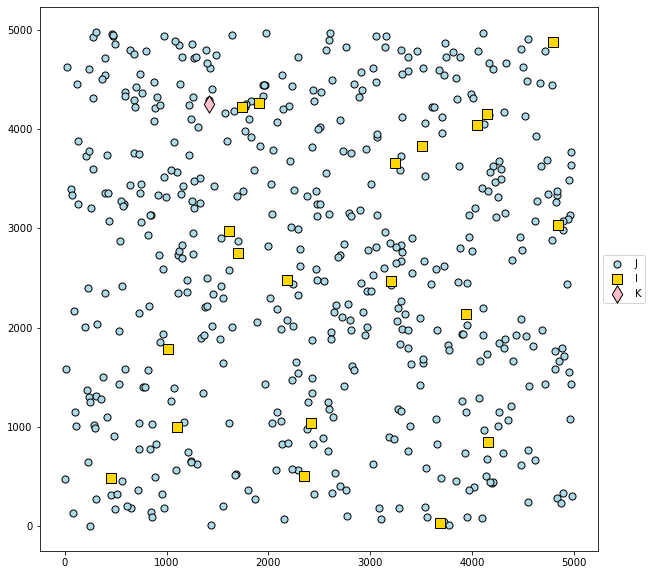

In [71]:
axs, fig = plt.subplots(1, 1, figsize = (10, 10))

fig.scatter(J['Longitude'], J['Latitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [72]:
# from pathlib import Path
# import pandas as pd
# import geopandas as gpd
# import shapely
# #%pip install folium matplotlib mapclassify
# import folium
# import matplotlib



# with open('Polygon Passau.txt', 'r') as file:
#     # Read the contents of the file into a string
#     polygon_str = file.read()

# # Making Passau polygon

# passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)

# passau_poly = shapely.wkt.loads(polygon_str)
# passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
# folium.GeoJson(passau_gdf).add_to(passau_map)


# # Assuming I_coordinates is your DataFrame with doctor coordinates
# geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_doctors.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.Marker([row['Latitude'], row['Longitude']],
#                   icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1),
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)

# geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_labs.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.Marker([row['Latitude'], row['Longitude']],
#                   icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1,
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)

# geo_bases = gpd.GeoDataFrame(J_coordinates, geometry=gpd.points_from_xy(J_coordinates["Latitude"], J_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_bases.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.CircleMarker([row['Latitude'], row['Longitude']],
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)


# #Custom legend

# legend_html = '''
#      <div style="position: fixed;
#                  bottom: 100px; right: 100px; width: 300px; height: 150px;
#                  border:2px solid grey; z-index:9999; font-size:16px;
#                  background-color:white; opacity: 0.9;
#                  ">
#      &nbsp; <i class="fa fa-map-marker fa-3x" style="color:orange"></i> Doctors &nbsp; <br>
#      &nbsp; <i class="fa fa-map-marker fa-3x" style="color:red"></i> Laboratories &nbsp; <br>
#      &nbsp; <svg height="40" width="40">
#           <circle cx="20" cy="20" r="18" fill="none" stroke="#3388FF" stroke-width="2" />
#         </svg> Bases &nbsp;
#       </div>
#      '''



# # Add the legend to the map
# passau_map.get_root().html.add_child(folium.Element(legend_html))

# passau_map

In [113]:
#Define constants

B = 91800 #battery load: meters of travel
S = 1020 #meters of service time
W = 2500 #max grams of weight

p = 0.95

alpha = 15900 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 203000
    else:
        beta[j] = 76920

gamma = 0.0045 / 1000 # variable cost in euro per m

q_j = {}
for j in J.index:
    if j.startswith('j'):
        q_j[j] = 255
    else:
        q_j[j] = 45



softlimit = 300
hardlimit = 10000

In [74]:
#Model termination function

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()

In [75]:
#mean = {i : random.uniform(500, 3000) for i in I.index}
std_dev = {i : random.uniform(2000, 5000) for i in I.index}

#Define random variable

theta_ran_i = {}
for i in list(I.index):
    theta_ran_i[i] = foldnorm(c=0, loc=0, scale=std_dev[i])
    #theta_ran_i[i] = foldnorm(c=0, loc=mean[i], scale=std_dev[i]) 
    
#Define deterministic theta
theta_det = {}
for i in I.index:
    theta_det[i] = theta_ran_i[i].rvs(1)[0]
    
r = len(theta_ran_i.keys()) #r-variate random vector theta

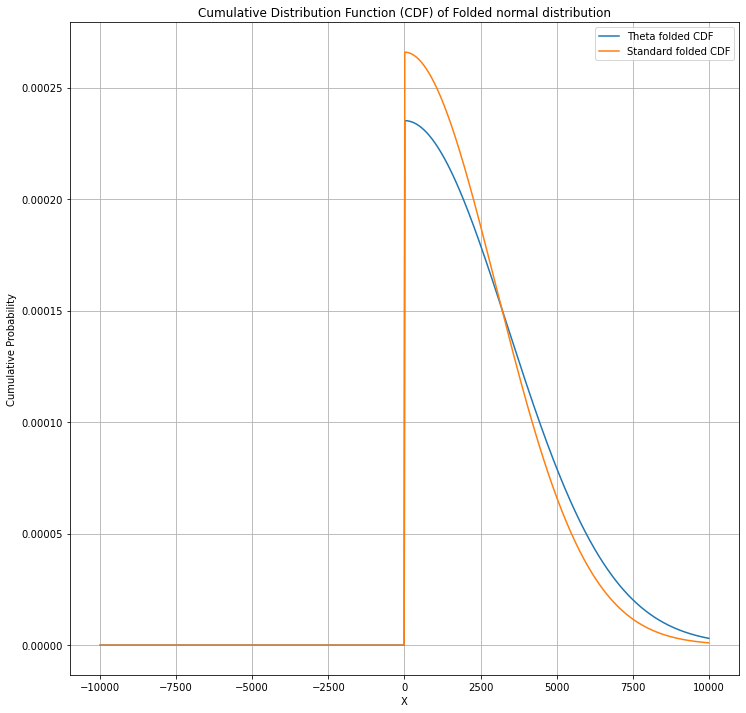

In [76]:
x = np.linspace(-10000, 10000, 1000)  # Generate 1000 points from 0 to 5
cdf = theta_ran_i['i0'].pdf(x)
cdf_foldnorm = foldnorm.pdf(x, c=0, loc=0, scale=3000)
cdf_norm = norm.pdf(x, loc=0, scale=1)
plt.figure(figsize=(12, 12))
plt.plot(x, cdf, label='Theta folded CDF')
plt.plot(x, cdf_foldnorm, label='Standard folded CDF')
#plt.plot(x, cdf_norm, label='Standard CDF')
plt.title('Cumulative Distribution Function (CDF) of Folded normal distribution')
plt.xlabel('X')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.legend()
plt.show()

Deterministic model DM

In [77]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Longitude'], PointsSet1.loc[point1, 'Latitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Longitude'], PointsSet2.loc[point2, 'Latitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}

dist_KJ


{('k0', 'j0'): 35.12833614050059,
 ('k0', 'j1'): 3081.2771702656028,
 ('k0', 'j2'): 1231.8185743038623,
 ('k0', 'j3'): 3065.6686057041456,
 ('k0', 'j4'): 4051.4543067891063,
 ('k0', 'j5'): 1134.4835829574617,
 ('k0', 'j6'): 1062.3483421175938,
 ('k0', 'j7'): 1027.5563244902928,
 ('k0', 'j8'): 1125.232420435885,
 ('k0', 'j9'): 3210.1347323749515,
 ('k0', 'j10'): 577.710134929274,
 ('k0', 'j11'): 2021.4670415319663,
 ('k0', 'j12'): 532.4143123545797,
 ('k0', 'j13'): 1789.3177470756837,
 ('k0', 'j14'): 1831.8657156025383,
 ('k0', 'j15'): 2450.4630174724125,
 ('k0', 'j16'): 2872.5363357144847,
 ('k0', 'j17'): 3723.993152517872,
 ('k0', 'j18'): 777.8849529332728,
 ('k0', 'j19'): 1929.1036778773712,
 ('k0', 'j20'): 1057.269123733404,
 ('k0', 'j21'): 4141.086330904006,
 ('k0', 'j22'): 3618.8666734213903,
 ('k0', 'j23'): 3540.1706173573048,
 ('k0', 'j24'): 5238.093641774649,
 ('k0', 'j25'): 1227.264030272215,
 ('k0', 'j26'): 3494.967811010568,
 ('k0', 'j27'): 834.4399319303936,
 ('k0', 'j28'):

In [78]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, int(v.X)))
                                #print(v)
                print("\n")

        print("\n")


In [79]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    total_drones = sum(results['Number of drones'])
    total_locations = results['j'].nunique()
    return results_doctors, results_locations, results_labs, f'Total number of drones: {total_drones}', f'Total number of locations: {total_locations}'


In [80]:
def SolutionGraph(I, K, J, model):

        axs, fig = plt.subplots(1, 1, figsize = (20, 20))

        fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Longitude'][i] - 40, I['Latitude'][i] - 15))

        fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Longitude'][k] - 40, K['Latitude'][k] - 15))

        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        (J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.plot((I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        #(I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                         #color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                #(K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                                fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                (J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                        if v.varName.startswith('y_j'):
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
                                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))


In [81]:
# def SolutionMap(I_coordinates, K_coordinates, J_coordinates, model):

#         with open('Polygon Passau.txt', 'r') as file:
#         # Read the contents of the file into a string
#                 polygon_str = file.read()

#         # Making Passau polygon
#         passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
#         passau_poly = shapely.wkt.loads(polygon_str)
#         passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
#         folium.GeoJson(passau_gdf).add_to(passau_map)

#         # Assuming I_coordinates is your DataFrame with doctor coordinates
#         geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326")

#         indices_xi = []
#         indices_y = pd.DataFrame(columns = ['Location name', 'Latitude', 'Longitude'])
#         indices_x = pd.DataFrame(columns = ['I', 'J', 'Number of drones'])


#         i = 0
#         for v in model.getVars():
#                 if v.x > 0:
#                         if v.varName.startswith('x_ikj'):
#                                 indices_xi = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
#                                 indices_x.loc[i, 'I'] = str(indices_xi[0])
#                                 indices_x.loc[i, 'J'] = str(indices_xi[2])
#                                 indices_x.loc[i, 'Number of drones'] = int(v.x)
#                                 i += 1

#                         else:
#                                 y_name = v.varName[4:-1]
#                                 indices_y.loc[str(y_name), 'Latitude'] = J_coordinates.loc[str(y_name), 'Latitude']
#                                 indices_y.loc[str(y_name), 'Longitude'] = J_coordinates.loc[str(y_name), 'Longitude']
#                                 indices_y.loc[str(y_name), 'Location name'] = str(y_name)
#                                 #
#                                 # fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
#                                 #         edgecolors = 'black', s = 100, marker = 'X', label = index_y)

#         geo_solution_y = gpd.GeoDataFrame(indices_y, geometry=gpd.points_from_xy(indices_y["Latitude"], indices_y["Longitude"]), crs="epsg:4326")



#         for idx, row in geo_doctors.iterrows():
#                 coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']],
#                         icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1),
#                         popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)



#         geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

#         for idx, row in geo_labs.iterrows():
#                 coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']],
#                                 icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1,
#                                 popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)


#         for idx, row in geo_solution_y.iterrows():
#                 coordinates_label = f"Loc: {row['Location name']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']],
#                         icon=folium.Icon(icon='circle', prefix='fa', color='green', size = 0.1),
#                         popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)


#         for idx, row in indices_x.iterrows():
#                 point_i = I_coordinates.loc[row['I'], ['Latitude', 'Longitude']]
#                 point_j = J_coordinates.loc[row['J'], ['Latitude', 'Longitude']]
#                 folium.PolyLine(locations=[(point_i['Latitude'], point_i['Longitude']),
#                                         (point_j['Latitude'], point_j['Longitude'])], color='blue').add_to(passau_map)

#                 label = str(row['Number of drones'])
#                 div_icon_style = "background-color: white; border-radius: 50%; padding: 5px;"

#                 circle_size = 20
#                 folium.Marker([(point_i['Latitude'] + point_j['Latitude']) / 2, (point_i['Longitude'] + point_j['Longitude']) / 2], icon=folium.DivIcon(
#                 html=f"<div style='{div_icon_style}; width: {circle_size}px; height: {circle_size}px;'><div style='font-size: 10pt; color: blue;'>{label}</div></div>")).add_to(passau_map)


#         return passau_map


In [82]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))

L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [83]:
#Redefine set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= B:
        P.append((i, k))

P

[('i0', 'k0'),
 ('i1', 'k0'),
 ('i2', 'k0'),
 ('i3', 'k0'),
 ('i4', 'k0'),
 ('i5', 'k0'),
 ('i6', 'k0'),
 ('i7', 'k0'),
 ('i8', 'k0'),
 ('i9', 'k0'),
 ('i10', 'k0'),
 ('i11', 'k0'),
 ('i12', 'k0'),
 ('i13', 'k0'),
 ('i14', 'k0'),
 ('i15', 'k0'),
 ('i16', 'k0'),
 ('i17', 'k0'),
 ('i18', 'k0'),
 ('i19', 'k0')]

In [84]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}

KJ_feas = list(M_kj_final.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j7'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j68'),

In [85]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []

N_i_final = {key : val for key, val in N_i.items() if val != []}

I_feas = list(N_i_final.keys())

In [86]:
#Redefine sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []

O_j_final = {key : val for key, val in O_j.items() if val != []}

J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j7',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j91',
 'j92',
 'j94',
 'j95',
 'j96',
 'j97',
 'j99',
 'j100',
 'j101',
 'j102',
 'j103',
 'j104',
 'j105',
 'j106',
 'j107',
 'j108',
 'j109',
 'j110',
 'j111',
 'j112',
 'j113',
 'j114',
 'j115',
 'j116',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j124',
 'j125',
 'j126',
 'j128',
 'j129',
 'j130',
 'j131',
 'j132',
 'j133',
 'j134'

Deterministic model (DM)

In [87]:

def AddBasisGurobi(model, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit):

    #Adding basic variables x_ikj and y_j
    x_ikj = model.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
    y_j = model.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')


    #Adding constraints except for demand covering
    model.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'Capacity')
    model.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'Battery')
    model.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'Service time')
    model.addConstrs((y_j[k] == 1 for k in K.index), name = 'Open laboratories')

    #Set objective
    model.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

    #Set parameter TimeLimit
    model.setParam('TimeLimit', hardlimit)

    return x_ikj, y_j


In [88]:

model_DM = gp.Model('DM')

x_ikj, y_j = AddBasisGurobi(model_DM, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

#Add demand constraints
model_DM.addConstrs((gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'Demand')

model_DM.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19291 rows, 10941 columns and 21641 nonzeros
Model fingerprint: 0x0243d55f
Variable types: 0 continuous, 10941 integer (521 binary)
Coefficient statistics:
  Matrix range     [9e-02, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+03]
Found heuristic solution: objective 4442720.8119
Presolve removed 18913 rows and 9593 columns
Presolve time: 0.00s
Presolved: 378 rows, 1348 columns, 2330 nonzeros
Found heuristic solution: objective 3630720.7851
Variable types: 0 continuous, 1348 integer (942 binary)
Found heuristic solution: objective 3630720.7706

Root relaxation: objective 1.049127e+06, 793 iterations, 0.00 seconds 

In [89]:
ListSolution(model_DM)

Number of solutions found: 6
0
1.17332e+06 
x_ikj[i0,k0,k0] 1
x_ikj[i1,k0,i11] 3
x_ikj[i2,k0,i17] 1
x_ikj[i3,k0,j335] 1
x_ikj[i4,k0,k0] 3
x_ikj[i5,k0,i12] 3
x_ikj[i6,k0,i6] 1
x_ikj[i7,k0,j335] 1
x_ikj[i8,k0,i9] 1
x_ikj[i9,k0,i9] 1
x_ikj[i10,k0,j335] 1
x_ikj[i11,k0,i11] 1
x_ikj[i12,k0,i12] 1
x_ikj[i13,k0,i12] 1
x_ikj[i14,k0,i12] 3
x_ikj[i15,k0,i11] 2
x_ikj[i16,k0,j335] 2
x_ikj[i17,k0,i17] 1
x_ikj[i18,k0,i6] 1
x_ikj[i19,k0,i6] 3
y_j[j335] 1
y_j[k0] 1
y_j[i6] 1
y_j[i9] 1
y_j[i11] 1
y_j[i12] 1
y_j[i17] 1


1
1.40408e+06 
x_ikj[i0,k0,k0] 1
x_ikj[i1,k0,i11] 3
x_ikj[i2,k0,i17] 1
x_ikj[i3,k0,j335] 1
x_ikj[i4,k0,k0] 3
x_ikj[i5,k0,i12] 3
x_ikj[i6,k0,i6] 1
x_ikj[i7,k0,j335] 1
x_ikj[i8,k0,i9] 1
x_ikj[i9,k0,i9] 1
x_ikj[i10,k0,j335] 1
x_ikj[i11,k0,i11] 1
x_ikj[i12,k0,i12] 1
x_ikj[i13,k0,i12] 1
x_ikj[i14,k0,i12] 3
x_ikj[i15,k0,i11] 2
x_ikj[i16,k0,j335] 2
x_ikj[i17,k0,i17] 1
x_ikj[i18,k0,i6] 1
x_ikj[i19,k0,i6] 3
y_j[j335] 1
y_j[k0] 1
y_j[i6] 1
y_j[i9] 1
y_j[i11] 1
y_j[i12] 1
y_j[i17] 1


2
1.76092e+06

In [90]:
SolutionSummary(model_DM)

(      i  Number of drones
 0    i0                 1
 1    i1                 3
 2   i10                 1
 3   i11                 1
 4   i12                 1
 5   i13                 1
 6   i14                 3
 7   i15                 2
 8   i16                 2
 9   i17                 1
 10  i18                 1
 11  i19                 3
 12   i2                 1
 13   i3                 1
 14   i4                 3
 15   i5                 3
 16   i6                 1
 17   i7                 1
 18   i8                 1
 19   i9                 1,
       j  Number of drones
 0   i11                 6
 1   i12                 8
 2   i17                 2
 3    i6                 5
 4    i9                 2
 5  j335                 5
 6    k0                 4,
     k  Number of drones
 0  k0                32,
 'Total number of drones: 32',
 'Total number of locations: 7')

In [91]:
#SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_DM)

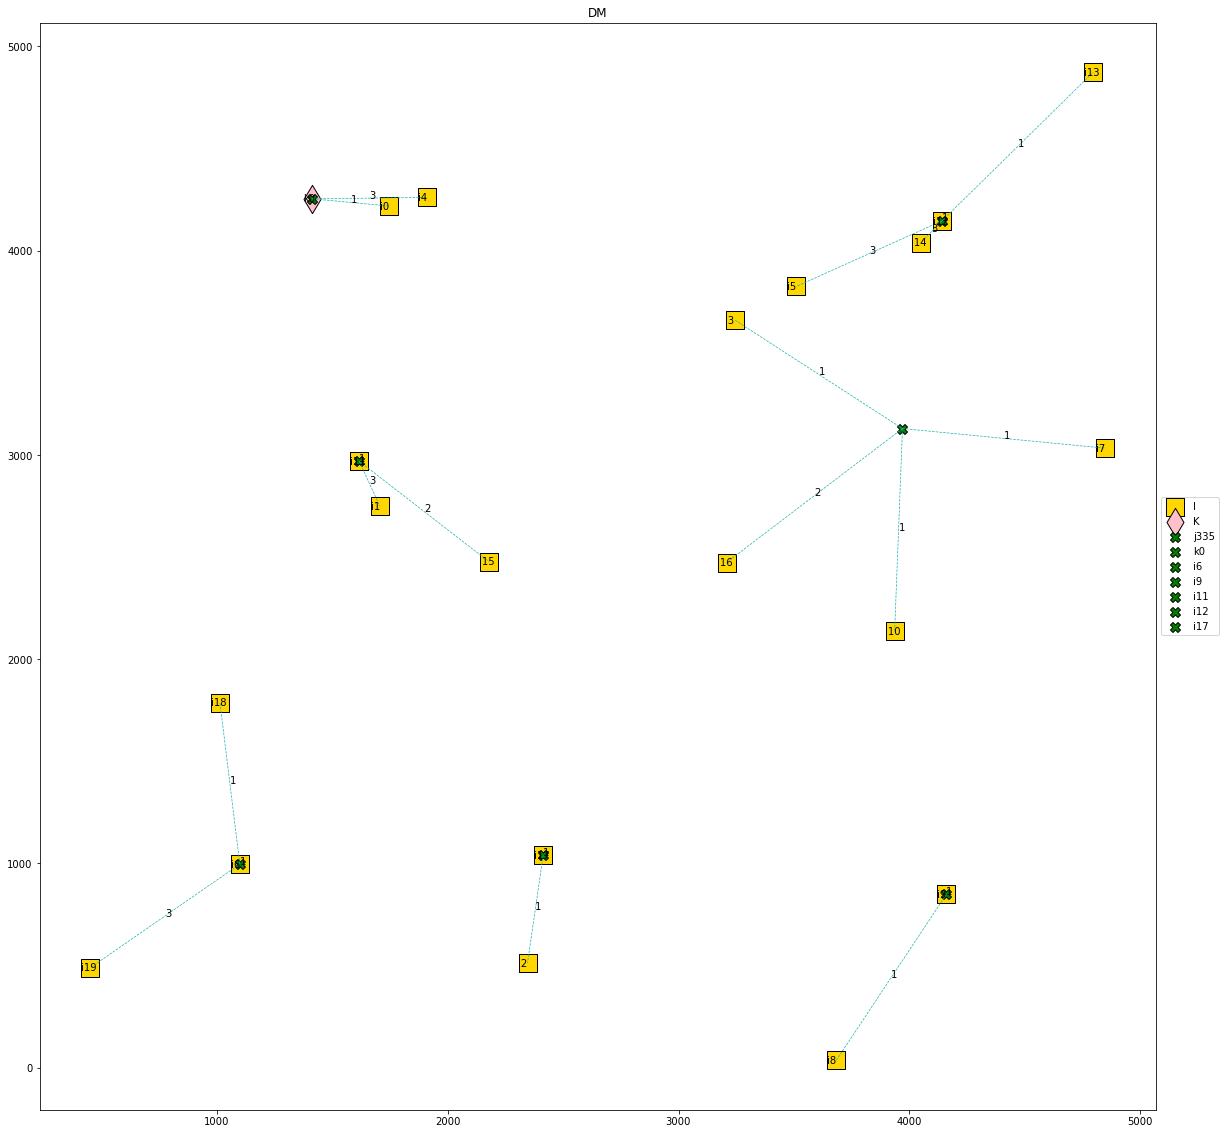

In [92]:
SolutionGraph(I, K, J, model_DM)

In [253]:
#for i in I_feas:
    
step = 0.01
ones = [1] * 25
foldnorm_cdf_values = np.round(np.arange(step, 1, step).tolist(), 3)
z_values = foldnorm.ppf(foldnorm_cdf_values, c=0, loc = 0, scale=std_dev['i0']).tolist()
foldnorm_cdf_values = np.append(foldnorm_cdf_values, ones)
foldnorm_cdf_values

for i in ones:
    z_values = np.append(z_values, z_values[-1]+50*i)

foldnorm_cdf_values

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  ])

In [254]:
model_BO1 = gp.Model('BO1')

eps = 0.00000000001

#model_BO1.Params.Presolve = 0

x_ikj, y_j = AddBasisGurobi(model_BO1, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

z_i = model_BO1.addVars(I_feas, vtype = GRB.CONTINUOUS, name = 'z_i')

F_i = model_BO1.addVars(I_feas, lb=0, ub=1, vtype = GRB.CONTINUOUS, name='F_i')
test_i = model_BO1.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_i')



for i in I_feas:
    
    #Generate mapping z->cdf
    step = 0.01
    ones = [1] * 25
    foldnorm_cdf_values = np.round(np.arange(step, 1, step).tolist(), 3)
    z_values = foldnorm.ppf(foldnorm_cdf_values, c=0, loc = 0, scale=std_dev[i]).tolist()
    foldnorm_cdf_values = np.append(foldnorm_cdf_values, ones)
    foldnorm_cdf_values
    
    for one in ones:
        z_values = np.append(z_values, z_values[-1]+50*one)
        
        
    
    model_BO1.addConstr(z_i[i] == gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]), name = 'Z-replacement')
    
    model_BO1.addGenConstrPWL(xvar=z_i[i], yvar=F_i[i], xpts=z_values, ypts=foldnorm_cdf_values, name="F=cdf(z_i)")
    model_BO1.update()
    
    #model_BO1.addConstr((F_i[i] >= p), name='Individual probabilistic constraint')
    model_BO1.addConstr(test_i[i] == F_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
    
    

model_BO1.addConstr((gp.quicksum(F_i[i] for i in I_feas) - r + 1 >= p), name='Joint probabilistic constraint')
    



Set parameter TimeLimit to value 10000


<gurobi.Constr *Awaiting Model Update*>

In [255]:
model_BO1.optimize(softtime)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19312 rows, 11001 columns and 21721 nonzeros
Model fingerprint: 0xa04bd63a
Model has 20 general constraints
Variable types: 60 continuous, 10941 integer (521 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+06]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
  PWLCon x range   [5e+01, 1e+04]
  PWLCon y range   [2e-02, 1e+00]
Presolve removed 18781 rows and 6847 columns
Presolve time: 0.02s
Presolved: 531 rows, 4154 columns, 10299 nonzeros
Presolved model has 20 SOS constraint(s)
Variable types: 2500 continuous, 1654 integer (469 binary)

Root relaxation: objective 1.365347e+06, 1330 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    C

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\\gurobipy\\callback.pxi", line 208, in gurobipy.CallbackClass.callback
  File "C:\Users\AleksandraPetrenko\AppData\Local\Temp\ipykernel_14832\4264144805.py", line 3, in softtime
KeyboardInterrupt: 


 743799 617308 2463756.62   81   42          - 1802230.90      -  13.7  465s
 749358 621436 2961581.41  112   49          - 1802324.51      -  13.7  470s
 754812 626142 2951831.84   54   69          - 1802495.05      -  13.7  475s


0.95

In [235]:
ListSolution(model_BO1)

Number of solutions found: 10
0
1.92062e+06 
x_ikj[i0,k0,k0] 3
x_ikj[i1,k0,i11] 4
x_ikj[i2,k0,i17] 3
x_ikj[i3,k0,j335] 4
x_ikj[i4,k0,k0] 4
x_ikj[i5,k0,j335] 1
x_ikj[i5,k0,i12] 3
x_ikj[i6,k0,i6] 3
x_ikj[i7,k0,j335] 12
x_ikj[i8,k0,i9] 3
x_ikj[i9,k0,i9] 4
x_ikj[i10,k0,j335] 4
x_ikj[i11,k0,i11] 4
x_ikj[i12,k0,i12] 4
x_ikj[i13,k0,i12] 2
x_ikj[i14,k0,j335] 0
x_ikj[i14,k0,i12] 2
x_ikj[i15,k0,i11] 3
x_ikj[i16,k0,j335] 4
x_ikj[i17,k0,i17] 4
x_ikj[i18,k0,i6] 4
x_ikj[i19,k0,i6] 3
y_j[j335] 1
y_j[k0] 1
y_j[i6] 1
y_j[i9] 1
y_j[i11] 1
y_j[i12] 1
y_j[i17] 1
z_i[i0] 7500
z_i[i1] 10000
z_i[i2] 7500
z_i[i3] 10000
z_i[i4] 10000
z_i[i5] 10000
z_i[i6] 7500
z_i[i7] 30000
z_i[i8] 7500
z_i[i9] 10000
z_i[i10] 10000
z_i[i11] 10000
z_i[i12] 10000
z_i[i13] 5000
z_i[i14] 7499
z_i[i15] 7500
z_i[i16] 10000
z_i[i17] 10000
z_i[i18] 10000
z_i[i19] 7500
F_i[i0] 0
F_i[i1] 0
F_i[i2] 0
F_i[i3] 1
F_i[i4] 0
F_i[i5] 0
F_i[i6] 0
F_i[i7] 1
F_i[i8] 0
F_i[i9] 0
F_i[i10] 0
F_i[i11] 0
F_i[i12] 0
F_i[i13] 0
F_i[i14] 0
F_i[i15] 0
F_i

In [226]:
SolutionSummary(model_BO1)

(      i  Number of drones
 0    i0                 3
 1    i1                 4
 2   i10                 4
 3   i11                 4
 4   i12                 4
 5   i13                 2
 6   i14                 2
 7   i15                 3
 8   i16                 4
 9   i17                 4
 10  i18                 4
 11  i19                 3
 12   i2                 3
 13   i3                 4
 14   i4                 4
 15   i5                 4
 16   i6                 3
 17   i7                12
 18   i8                 3
 19   i9                 4,
       j  Number of drones
 0   i11                11
 1   i12                11
 2   i17                 7
 3    i6                10
 4    i9                 7
 5  j335                25
 6    k0                 7,
     k  Number of drones
 0  k0                78,
 'Total number of drones: 78',
 'Total number of locations: 7')

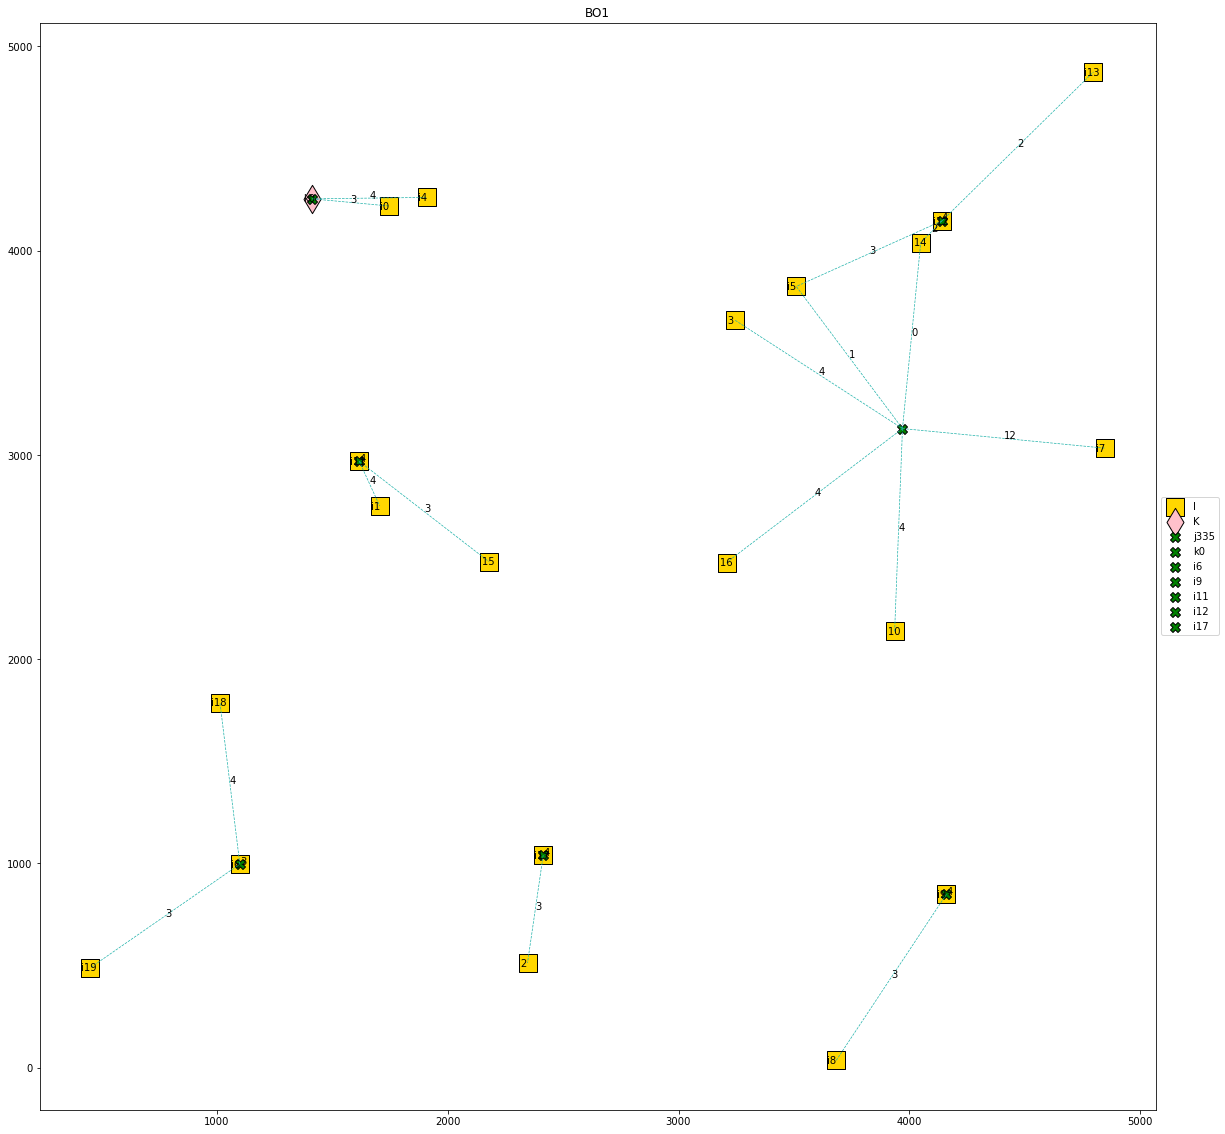

In [228]:
SolutionGraph(I, K, J, model_BO1)

In [ ]:
print(model_BO1.ObjVal, model_DM.ObjVal)

1761621.7769894307 1252820.9268052643
